# Data processing

## Background

The fake vs real news dataset has been downloaded from [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). This data set includes data for 21,417 articles considered to be 'real' news and 23,481 articles considered to be fake news.

The stated task is: can you use this data set to make an algorithm able to determine if an article is fake news or not ?

## Import packages

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats import weightstats as stests

## Read in datasets

In [2]:
real_df = pd.read_csv('~/documents/Data/Fake vs Real News/True.csv')
fake_df = pd.read_csv('~/documents/Data/Fake vs Real News/Fake.csv')

## Exploratory data analysis

### Shape

In [3]:
print(real_df.shape)
print(fake_df.shape)

(21417, 4)
(23481, 4)


### Column names

In [229]:
print(real_df.columns, '\n')
print(fake_df.columns)

Index(['title', 'text', 'length_title', 'number_capitals_title', 'length_text',
       'proportion_capitals_title'],
      dtype='object') 

Index(['title', 'text', 'length_title', 'number_capitals_title', 'length_text',
       'proportion_capitals_title'],
      dtype='object')


### Data types

In [5]:
print(real_df.dtypes, '\n')
print(fake_df.dtypes)

title      object
text       object
subject    object
date       object
dtype: object 

title      object
text       object
subject    object
date       object
dtype: object


### Drop irrelevant columns

In [6]:
print(pd.unique(real_df['subject']))
print(pd.unique(fake_df['subject']))

['politicsNews' 'worldnews']
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


There is no overlap of the subjects in the real dataset and those in the fake dataset. This means that you could create a model that correctly predicts real vs fake news in this data set with 100% accuracy. However, this is not a meaningful distinction, and the model would not generalise well to other datasets. Therefore, I choose to discard this column to reduce the dimensionality of the problem and avoid overfitting.

In [7]:
real_df = real_df.drop('subject', axis = 1)
fake_df = fake_df.drop('subject', axis = 1)

In [8]:
print(real_df.columns, '\n')
print(fake_df.columns)

Index(['title', 'text', 'date'], dtype='object') 

Index(['title', 'text', 'date'], dtype='object')


### Rename columns

No need to rename columns in this case. Their meaning is clear.

### Check for duplicate rows

In [9]:
print(real_df.duplicated().sum())
print(fake_df.duplicated().sum())

217
5571


### Drop duplicate rows

In [10]:
real_df = real_df.drop_duplicates()
fake_df = fake_df.drop_duplicates()

In [11]:
print(real_df.shape)
print(fake_df.shape)

(21200, 3)
(17910, 3)


### Check for null or NA values

In [12]:
print(real_df.isna().sum(), '\n')
print(fake_df.isna().sum(), '\n')

title    0
text     0
date     0
dtype: int64 

title    0
text     0
date     0
dtype: int64 



### Date column

Convert date column to datetime object.

In [16]:
real_df['date'] = pd.to_datetime(real_df['date'], errors = 'coerce')
fake_df['date'] = pd.to_datetime(fake_df['date'], errors = 'coerce')

Number of rows for which the conversion failed, i.e. with invalid datetime objects in the date column.

In [32]:
print(sum(real_df['date'].isnull()))
print(sum(fake_df['date'].isnull()))

0
0


This is a trivial number compared to the total number of rows, so it is OK to drop these rows.

In [33]:
fake_df = fake_df[fake_df['date'].notnull()]

In [34]:
print(real_df.dtypes, '\n')
print(fake_df.dtypes)

title            object
text             object
date     datetime64[ns]
dtype: object 

title            object
text             object
date     datetime64[ns]
dtype: object


Earliest and latest dates.

In [35]:
print(real_df['date'].min())
print(real_df['date'].max(), '\n')
print(fake_df['date'].min())
print(fake_df['date'].max())

2016-01-13 00:00:00
2017-12-31 00:00:00 

2015-03-31 00:00:00
2018-02-19 00:00:00


In [216]:
def plot_comparison_histogram(real_df, fake_df, variable_to_plot, title, xlabel, bins = None, xlim = None):
    fig, ax = plt.subplots()
    sns.distplot(real_df[variable_to_plot], bins = bins, kde = False)
    sns.distplot(fake_df[variable_to_plot], bins = bins, kde = False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    ax.legend(['Real news', 'Fake news'])
    plt.xlim(left = 0, right = xlim)
    plt.show()

KeyError: 'date'

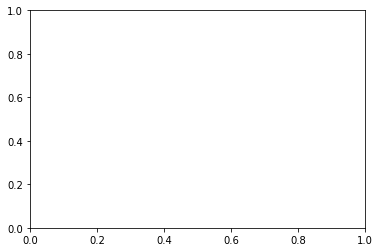

In [217]:
plot_comparison_histogram(real_df, fake_df, 'date',
                          title = 'Histogram of publication dates of news articles',
                         xlabel = 'Date',
                         bins = 66, xlim = 1)

It appears there are structural differences between the real news data and the fake news data that do not appear to be meaningfully linked to the verisimilitude of the data, and would likely to obscure any genuine features. Therefore, I believe it would make sense to remove this column to reduce the dimensionality of the problem and avoid overfitting.

In [66]:
real_df = real_df.drop('date', axis = 1)
fake_df = fake_df.drop('date', axis = 1)

In [67]:
print(real_df.columns, '\n')
print(fake_df.columns)

Index(['title', 'text'], dtype='object') 

Index(['title', 'text'], dtype='object')


### Length of title

I hypothesise that there is likely to be a relationship between the number of characters in the title of an article and the article's verisimilitude.

In [213]:
real_df['length_title'] = [len(x) for x in real_df['title']]
fake_df['length_title'] = [len(x) for x in fake_df['title']]

#### Histogram

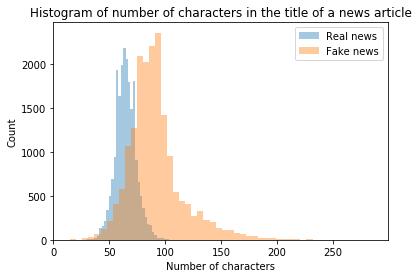

In [218]:
plot_comparison_histogram(real_df, fake_df, 'length_title',
                          title = 'Histogram of number of characters in the title of a news article',
                          xlabel = 'Number of characters')

By visual inspection, the histogram shows there is likely to be a relationship between the number of characters in the title of the article and the article's verisimilitude, i.e. that an article with a longer title is more likely to be fake news.

#### Independent sample t-test

In [102]:
t, p = stats.ttest_ind(real_df['length_title'], fake_df['length_title'])
print("t = " + str(t))
print("p = " + str(p))

t = -146.33552656627356
p = 0.0


The p value approximates to zero, suggesting there is strong evidence that the means of these two samples are different, which supports the hypothesis.

### Length of body of article

I hypothesise that there is likely to be a relationship between the number of characters in the body of an article and the article's verisimilitude.

In [182]:
real_df['length_text'] = [len(x) for x in real_df['text']]
fake_df['length_text'] = [len(x) for x in fake_df['text']]

#### Histogram

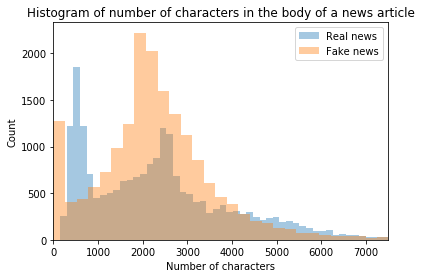

In [224]:
plot_comparison_histogram(real_df, fake_df, 'length_text',
                          title = 'Histogram of number of characters in the body of a news article',
                          xlabel = 'Number of characters',
                         bins = 200, xlim = 7500)

By visual inspection, the histogram shows there may be a relationship between the number of characters in the body of an article and the article's verisimilitude, but this is a complex non-linear relationship that may be a result of structural differences in the data. I will therefore remove this column to reduce the dimensionality of the problem and avoid overfitting to the data.

In [180]:
real_df = real_df.drop('length_text', axis = 1)
fake_df = fake_df.drop('length_text', axis = 1)

### Number of capital letters in title

I hypothesise that there is a relationship between the number or proportion of capital letters in an article's title and the article's verisimilitude.

In [196]:
def get_number_capitals(input_array, num_or_prop):
    'Takes a list of string objects and returns a list of the number or proportion of capital letters in each string.'
    output_array = []
    
    for i in range(len(input_array)):
        number_capitals = sum([x.isupper() for x in input_array.iloc[i]])
        
        if num_or_prop == 'num':
            output_array.append(number_capitals)
        elif num_or_prop == 'prop':
            proportion_capitals = number_capitals / len(input_array.iloc[i])
            output_array.append(proportion_capitals)
    
    return output_array

In [197]:
real_df['number_capitals_title'] = get_number_capitals(real_df['title'], num_or_prop = 'num')
fake_df['number_capitals_title'] = get_number_capitals(fake_df['title'], num_or_prop = 'num')

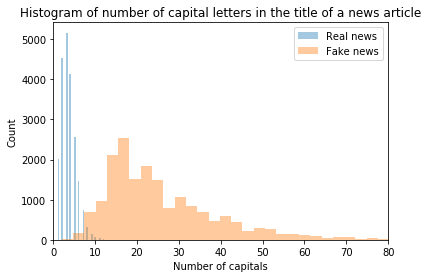

In [228]:
plot_comparison_histogram(real_df, fake_df, 'number_capitals_title',
                          title = 'Histogram of number of capital letters in the title of a news article',
                          xlabel = 'Number of capitals',
                         xlim = 80)

#### Independent sample t-test

In [185]:
t, p = stats.ttest_ind(real_df['number_capitals_title'], fake_df['number_capitals_title'])
print("t = " + str(t))
print("p = " + str(p))

t = -229.5815654283654
p = 0.0


The p value approximates to zero, suggesting there is strong evidence that the means of these two samples are different, which supports the hypothesis.

In [199]:
real_df['proportion_capitals_title'] = get_number_capitals(real_df['title'], num_or_prop = 'prop')
fake_df['proportion_capitals_title'] = get_number_capitals(fake_df['title'], num_or_prop = 'prop')

#### Histogram

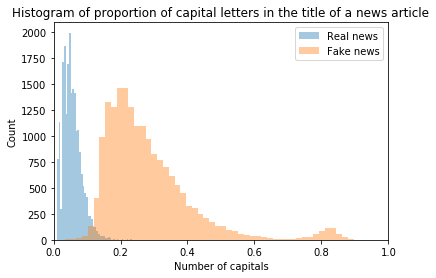

In [230]:
plot_comparison_histogram(real_df, fake_df, 'proportion_capitals_title',
                          title = 'Histogram of proportion of capital letters in the title of a news article',
                          xlabel = 'Number of capitals',
                         xlim = 1)

In [231]:
t, p = stats.ttest_ind(real_df['proportion_capitals_title'], fake_df['proportion_capitals_title'])
print("t = " + str(t))
print("p = " + str(p))

t = -237.10860715086307
p = 0.0


The p value approximates to zero, suggesting there is strong evidence that the means of these two samples are different, which supports the hypothesis.

The proportion_capitals_title than number_capitals_title. I will therefore remove 